# Towards a loss function for YOLO
Writing the second part of the YOLO series took a lot longer than I care to
admit... but, it's finally here! In this part we'll go over the definition of a
loss function to *train* the YOLO architecture.

## Index
* [part 1: introduction to YOLO and TinyYOLOv2 implementation](yolo-
part-1.ipynb)
* **part 2 (this post): towards a YOLO loss function**
* part 3 (in progress): transfer learning with YOLO

In [1]:
#!
import os
import glob
import torch
import tarfile
import numpy as np
import torchvision
import urllib.request
from PIL import Image, ImageDraw
from IPython.display import display
from tqdm.notebook import trange, tqdm

torch.manual_seed(33)
np.random.seed(42)

# the VOC object classes.
CLASSES = (
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "pottedplant",
    "sheep",
    "sofa",
    "train",
    "tvmonitor",
)
CLASS2NUM = {class_:idx for idx, class_ in enumerate(CLASSES)}

# download the VOC dataset if it's not already downloaded.
if not os.path.exists("VOCdevkit"):
    if not os.path.exists("VOC.tar"):
        urllib.request.urlretrieve(
            "https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar", "VOC.tar"
        )
    with tarfile.open("VOC.tar") as tar:
        tar.extractall()

# download pre-trained YOLO weights
if not os.path.exists("yolov2-tiny-voc.weights"):
    urllib.request.urlretrieve(
        "https://pjreddie.com/media/files/yolov2-tiny-voc.weights",
        "yolov2-tiny-voc.weights",
    )

class TinyYOLOv2(torch.nn.Module):
    def __init__(
        self,
        num_classes=20,
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
    ):
        super().__init__()

        # Parameters
        self.register_buffer("anchors", torch.tensor(anchors))
        self.num_classes = num_classes

        # Layers
        self.relu = torch.nn.LeakyReLU(0.1, inplace=True)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.slowpool = torch.nn.MaxPool2d(2, 1)
        self.pad = torch.nn.ReflectionPad2d((0, 1, 0, 1))
        self.norm1 = torch.nn.BatchNorm2d(16, momentum=0.1)
        self.conv1 = torch.nn.Conv2d(3, 16, 3, 1, 1, bias=False)
        self.norm2 = torch.nn.BatchNorm2d(32, momentum=0.1)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, 1, 1, bias=False)
        self.norm3 = torch.nn.BatchNorm2d(64, momentum=0.1)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, 1, 1, bias=False)
        self.norm4 = torch.nn.BatchNorm2d(128, momentum=0.1)
        self.conv4 = torch.nn.Conv2d(64, 128, 3, 1, 1, bias=False)
        self.norm5 = torch.nn.BatchNorm2d(256, momentum=0.1)
        self.conv5 = torch.nn.Conv2d(128, 256, 3, 1, 1, bias=False)
        self.norm6 = torch.nn.BatchNorm2d(512, momentum=0.1)
        self.conv6 = torch.nn.Conv2d(256, 512, 3, 1, 1, bias=False)
        self.norm7 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv7 = torch.nn.Conv2d(512, 1024, 3, 1, 1, bias=False)
        self.norm8 = torch.nn.BatchNorm2d(1024, momentum=0.1)
        self.conv8 = torch.nn.Conv2d(1024, 1024, 3, 1, 1, bias=False)
        self.conv9 = torch.nn.Conv2d(1024, len(anchors) * (5 + num_classes), 1, 1, 0)

    def forward(self, x, yolo=True):
        x = self.relu(self.pool(self.norm1(self.conv1(x))))
        x = self.relu(self.pool(self.norm2(self.conv2(x))))
        x = self.relu(self.pool(self.norm3(self.conv3(x))))
        x = self.relu(self.pool(self.norm4(self.conv4(x))))
        x = self.relu(self.pool(self.norm5(self.conv5(x))))
        x = self.relu(self.slowpool(self.pad(self.norm6(self.conv6(x)))))
        x = self.relu(self.norm7(self.conv7(x)))
        x = self.relu(self.norm8(self.conv8(x)))
        x = self.conv9(x)
        if yolo:
            x = self.yolo(x)
        return x

    def yolo(self, x):
        # store the original shape of x
        nB, _, nH, nW = x.shape

        # reshape the x-tensor: (batch size, # anchors, height, width, 5+num_classes)
        x = x.view(nB, self.anchors.shape[0], -1, nH, nW).permute(0, 1, 3, 4, 2)

        # get normalized auxiliary tensors
        range_y, range_x = torch.meshgrid(
            torch.arange(nH, dtype=x.dtype, device=x.device),
            torch.arange(nW, dtype=x.dtype, device=x.device),
        )
        anchor_x = self.anchors[:, 0].to(dtype=x.dtype, device=x.device)
        anchor_y = self.anchors[:, 1].to(dtype=x.dtype, device=x.device)

        # compute boxes.
        x = torch.cat([
            (x[:, :, :, :, 0:1].sigmoid() + range_x[None,None,:,:,None]) / nW,  # X center
            (x[:, :, :, :, 1:2].sigmoid() + range_y[None,None,:,:,None]) / nH,  # Y center
            (x[:, :, :, :, 2:3].exp() * anchor_x[None,:,None,None,None]) / nW,  # Width
            (x[:, :, :, :, 3:4].exp() * anchor_y[None,:,None,None,None]) / nH,  # Height
            x[:, :, :, :, 4:5].sigmoid(), # confidence
            x[:, :, :, :, 5:].softmax(-1), # classes
        ], -1)

        return x # (batch_size, # anchors, height, width, 5+num_classes)

def load_weights(network, filename="yolov2-tiny-voc.weights"):
    with open(filename, "rb") as file:
        version = np.fromfile(file, count=3, dtype=np.int32)
        seen_so_far = np.fromfile(file, count=1, dtype=np.int32)
        weights = np.fromfile(file, dtype=np.float32)
        idx = 0
        for layer in network.children():
            if isinstance(layer, torch.nn.Conv2d):
                if layer.bias is not None:
                    n = layer.bias.numel()
                    layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                    idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
            if isinstance(layer, torch.nn.BatchNorm2d):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n
                layer.running_mean.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_mean)
                idx += n
                layer.running_var.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.running_var)
                idx += n
            if isinstance(layer, torch.nn.Linear):
                n = layer.bias.numel()
                layer.bias.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.bias.data)
                idx += n
                n = layer.weight.numel()
                layer.weight.data[:] = torch.from_numpy(weights[idx : idx + n]).view_as(layer.weight.data)
                idx += n

def to_pil(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:  # single image
        return transform(x)
    elif x.dim() == 4:  # batch of images
        return [transform(xx) for xx in x]
    else:
        raise ValueError


def show_images(x):
    transform = torchvision.transforms.ToPILImage()
    if x.dim() == 3:
        display(transform(x))
    elif x.dim() == 4:
        for xx in x:
            display(transform(xx))
    else:
        raise ValueError

def load_image(idx, size, device="cpu"):
    filename = f"VOCdevkit/VOC2012/JPEGImages/2008_{str(idx).zfill(6)}.jpg"
    img = Image.open(filename)
    transforms = [torchvision.transforms.ToTensor()]
    try:
        width, height = size
    except TypeError:
        width = height = size
    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width, diff_height = width - new_width, height - new_height
    resize = torchvision.transforms.Resize(size=(new_height, new_width))
    pad = torchvision.transforms.Pad(
        padding=(
            diff_width // 2,
            diff_height // 2,
            diff_width // 2 + diff_width % 2,
            diff_height // 2 + diff_height % 2,
        )
    )
    transforms = [resize, pad] + transforms
    transformation = torchvision.transforms.Compose(transforms)
    x = transformation(img).to(device)
    return x

def load_image_batch(idxs, size, device="cpu"):
    imgs = [load_image(idx, size=size, device="cpu") for idx in idxs]
    x = torch.stack(imgs, 0)
    return x.to(device)

def show_images_with_boxes(input_tensor, output_tensor):
    to_img = torchvision.transforms.ToPILImage()
    for img, predictions in zip(input_tensor, output_tensor):
        img = to_img(img)
        if 0 in predictions.shape: # empty tensor
            display(img)
            continue
        confidences = predictions[..., 4].flatten()
        boxes = (
            predictions[..., :4].contiguous().view(-1, 4)
        )  # only take first four features: x0, y0, w, h
        classes = predictions[..., 5:].contiguous().view(boxes.shape[0], -1)
        boxes[:, ::2] *= img.width
        boxes[:, 1::2] *= img.height
        boxes = (torch.stack([
            boxes[:, 0] - boxes[:, 2] / 2,
            boxes[:, 1] - boxes[:, 3] / 2,
            boxes[:, 0] + boxes[:, 2] / 2,
            boxes[:, 1] + boxes[:, 3] / 2,
        ], -1, ).cpu().to(torch.int32).numpy())
        for box, confidence, class_ in zip(boxes, confidences, classes):
            if confidence < 0.01:
                continue # don't show boxes with very low confidence
            # make sure the box fits within the picture:
            box = [
                max(0, int(box[0])),
                max(0, int(box[1])),
                min(img.width - 1, int(box[2])),
                min(img.height - 1, int(box[3])),
            ]
            try:  # either the class is given as the sixth feature
                idx = int(class_.item())
            except ValueError:  # or the 20 softmax probabilities are given as features 6-25
                idx = int(torch.max(class_, 0)[1].item())
            try:
                class_ = CLASSES[idx]  # the first index of torch.max is the argmax.
            except IndexError: # if the class index does not exist, don't draw anything:
                continue

            color = (  # green color when confident, red color when not confident.
                int((1 - (confidence.item())**0.8) * 255),
                int((confidence.item())**0.8 * 255),
                0,
            )

            draw = ImageDraw.Draw(img)
            draw.rectangle(box, outline=color)
            draw.text(box[:2], class_, fill=color)

        display(img)

def filter_boxes(output_tensor, threshold):
    b, a, h, w, c = output_tensor.shape
    x = output_tensor.contiguous().view(b, a * h * w, c)

    boxes = x[:, :, 0:4]
    confidence = x[:, :, 4]
    scores, idx = torch.max(x[:, :, 5:], -1)
    idx = idx.float()
    scores = scores * confidence
    mask = scores > threshold

    filtered = []
    for c, s, i, m in zip(boxes, scores, idx, mask):
        if m.any():
            detected = torch.cat([c[m, :], s[m, None], i[m, None]], -1)
        else:
            detected = torch.zeros((0, 6), dtype=x.dtype, device=x.device)
        filtered.append(detected)
    return filtered

def iou_wh(bboxes1, bboxes2):
    """ calculate iou between each bbox in `bboxes1` with each bbox in `bboxes2`

    The bboxes should be defined by their width and height and are centered around (0,0)

    """

    w1 = bboxes1[..., 0]
    h1 = bboxes1[..., 1]
    w2 = bboxes2[..., 0]
    h2 = bboxes2[..., 1]

    intersections = torch.min(w1[:,None],w2[None,:]) * torch.min(h1[:,None],h2[None,:])
    unions = (w1 * h1)[:,None] + (w2 * h2)[None,:] - intersections
    ious = intersections / unions

    return ious

def iou(bboxes1, bboxes2):
    """ calculate iou between each bbox in `bboxes1` with each bbox in `bboxes2`"""
    px, py, pw, ph = bboxes1[...,:4].reshape(-1, 4).split(1, -1)
    lx, ly, lw, lh = bboxes2[...,:4].reshape(-1, 4).split(1, -1)
    px1, py1, px2, py2 = px - 0.5 * pw, py - 0.5 * ph, px + 0.5 * pw, py + 0.5 * ph
    lx1, ly1, lx2, ly2 = lx - 0.5 * lw, ly - 0.5 * lh, lx + 0.5 * lw, ly + 0.5 * lh
    zero = torch.tensor(0.0, dtype=px1.dtype, device=px1.device)
    dx = torch.max(torch.min(px2, lx2.T) - torch.max(px1, lx1.T), zero)
    dy = torch.max(torch.min(py2, ly2.T) - torch.max(py1, ly1.T), zero)
    intersections = dx * dy
    pa = (px2 - px1) * (py2 - py1) # area
    la = (lx2 - lx1) * (ly2 - ly1) # area
    unions = (pa + la.T) - intersections
    ious = (intersections/unions).reshape(*bboxes1.shape[:-1], *bboxes2.shape[:-1])
    return ious

def nms(filtered_tensor, threshold):
    result = []
    for x in filtered_tensor:
        # Sort coordinates by descending score
        scores, order = x[:, 4].sort(0, descending=True)
        x = x[order]
        ious = iou(x,x)

        # Filter based on iou
        keep = (ious > threshold).long().triu(1).sum(0, keepdim=True).t().expand_as(x) == 0

        result.append(x[keep].view(-1, 6).contiguous())
    return result


network = TinyYOLOv2()
load_weights(network)

In the previous post, we saw how to make bounding box predictions with YOLO. But
how do they compare with the ground truth boxes? For this we need a way to load
the ground truths:

In [2]:
def load_bboxes(idx, size, num_bboxes=None, device="cpu"):
    boxfilename = f"VOCdevkit/VOC2012/Annotations/2008_{str(idx).zfill(6)}.xml"
    imgfilename = f"VOCdevkit/VOC2012/JPEGImages/2008_{str(idx).zfill(6)}.jpg"
    img = Image.open(imgfilename) # img won't be loaded into memory, just needed for metadata.
    try:
        width, height = size
    except TypeError:
        width = height = size
    scale = min(width / img.width, height / img.height)
    new_width, new_height = int(img.width * scale), int(img.height * scale)
    diff_width  = (width - new_width)/width*img.width
    diff_height = (height - new_height)/height*img.height
    bboxes = []
    with open(boxfilename, "r") as file:
        for line in file:
            if "<name>" in line:
                class_ = line.split("<name>")[-1].split("</name>")[0].strip()
            elif "<xmin>" in line:
                x0 = float(line.split("<xmin>")[-1].split("</xmin>")[0].strip())
            elif "<xmax>" in line:
                x1 = float(line.split("<xmax>")[-1].split("</xmax>")[0].strip())
            elif "<ymin>" in line:
                y0 = float(line.split("<ymin>")[-1].split("</ymin>")[0].strip())
            elif "<ymax>" in line:
                y1 = float(line.split("<ymax>")[-1].split("</ymax>")[0].strip())
            elif "</object>" in line:
                if class_ not in CLASS2NUM:
                    continue
                bbox = [
                    (diff_width/2 + (x0+x1)/2) / (img.width + diff_width), # center x
                    (diff_height/2 + (y0+y1)/2) / (img.height + diff_height), # center y
                    (max(x0,x1) - min(x0,x1)) / (img.width + diff_width), # width
                    (max(y0,y1) - min(y0,y1)) / (img.height + diff_height), # height
                    1.0, # confidence
                    CLASS2NUM[class_], # class idx
                ]
                bboxes.append((bbox[2]*bbox[3]*(img.width+diff_width)*(img.height+diff_height),bbox))

    bboxes = torch.tensor([bbox for _, bbox in sorted(bboxes)], dtype=torch.get_default_dtype(), device=device)
    if num_bboxes:
        if num_bboxes > len(bboxes):
            zeros = torch.zeros((num_bboxes - bboxes.shape[0], 6), dtype=torch.get_default_dtype(), device=device)
            zeros[:, -1] = -1
            bboxes = torch.cat([bboxes, zeros], 0)
        elif num_bboxes < len(bboxes):
            bboxes = bboxes[:num_bboxes]

    return bboxes

def load_bboxes_batch(idxs, size, num_bboxes, device="cpu"):
    bboxes = [load_bboxes(idx, size, num_bboxes=num_bboxes, device="cpu") for idx in idxs]
    bboxes = torch.stack(bboxes, 0)
    return bboxes

labels:


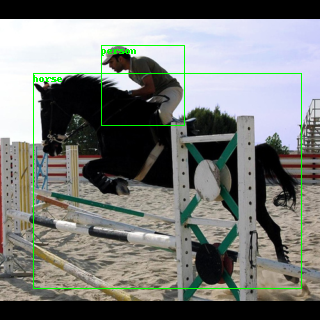

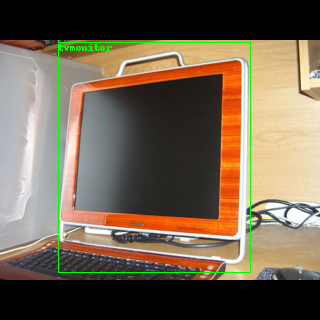

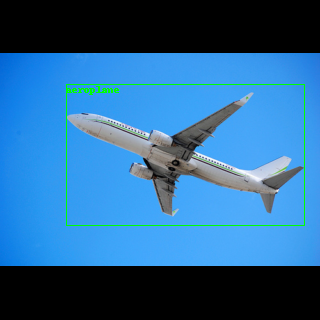

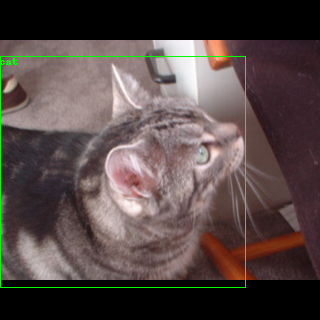

predictions:


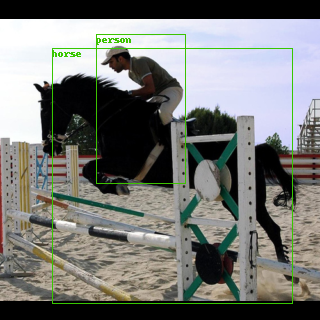

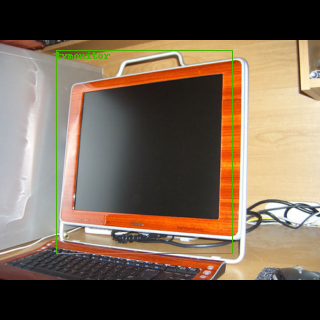

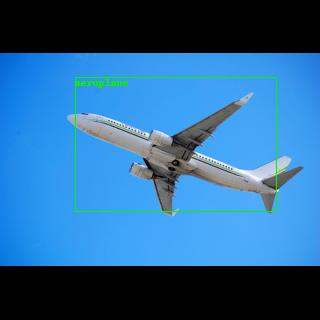

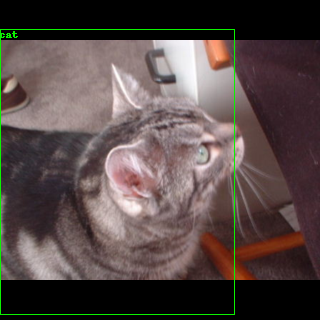

In [3]:
batch_imgs = load_image_batch([8,16,33,60], size=320)
batch_labels = load_bboxes_batch([8,16,33,60], size=330, num_bboxes=10)
batch_predictions = network(batch_imgs)

print("labels:")
show_images_with_boxes(batch_imgs, batch_labels)
print("predictions:")
show_images_with_boxes(batch_imgs, nms(filter_boxes(batch_predictions, 0.2), 0.5))

We can visually see that these labels correspond quite well to the predictions.
But we need a way to quantify how well.

## YOLO Loss function
Quantifying how well each predicted bounding box fits the bounding box labels
can be done by defining a custom loss function. However, in the case of YOLO,
this is a big deal. The loss function used to train YOLO from scratch is this
monster (adapted for YOLOv2):

$$
\begin{align*}
\lambda_\textbf{coord}&
\sum_{i = 0}^{M\times N}
\sum_{j = 0}^{A}
     {{1}}_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\\
+ \lambda_\textbf{coord}&
\sum_{i = 0}^{M\times N}
\sum_{j = 0}^{A}
         {{1}}_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ &\sum_{i = 0}^{M\times N}
\sum_{j = 0}^{A}
        {{1}}_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}&
\sum_{i = 0}^{M\times N}
\sum_{j = 0}^{A}
    {{1}}_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ &\sum_{i = 0}^{M\times N}
\sum_{j = 0}^{A}
{{1}}_{ij}^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{align*}
$$

This loss function can be broken down as follows.
* The summation $\sum_{i = 0}^{M\times N}$ that's present in every term of the
loss is the sumation over each of the predictions (`# anchors`$\times$ `#
x-values` $\times$`# y-values`).
* The first term of this loss function describes the sum-squared error between
the center coordinates of each predicted bounding box.
* The second term describes the sum-squared error of the *square root* of the
widths/heights. The square root is there to (partially) reduce the importance of
variations on larger bounding boxes vs smaller bounding boxes.
* The third term describes the sum-squared error in the confidences for boxes
that *do* contain objects
* The fourth term describes the sum-squared error in the confidences for boxes
that *don't* contain objects
* Finally, the last term describes the sum-squared error on the classification
vector, but only if an object is present in the bounding box.

In [4]:
class YOLOLoss(torch.nn.modules.loss._Loss):
    """ A loss function to train YOLO v2

    Args:
        anchors (optional, list): the list of anchors (should be the same anchors as the ones defined in the YOLO class)
        seen (optional, torch.Tensor): the number of images the network has already been trained on
        coord_prefill (optional, int): the number of images for which the predicted bboxes will be centered in the image
        threshold (optional, float): minimum iou necessary to have a predicted bbox match a target bbox
        lambda_coord (optional, float): hyperparameter controlling the importance of the bbox coordinate predictions
        lambda_noobj (optional, float): hyperparameter controlling the importance of the bboxes containing no objects
        lambda_obj (optional, float): hyperparameter controlling the importance of the bboxes containing objects
        lambda_cls (optional, float): hyperparameter controlling the importance of the class prediction if the bbox contains an object
    """
    def __init__(
        self,
        anchors=(
            (1.08, 1.19),
            (3.42, 4.41),
            (6.63, 11.38),
            (9.42, 5.11),
            (16.62, 10.52),
        ),
        seen=0,
        coord_prefill=12800,
        threshold=0.6,
        lambda_coord=1.0,
        lambda_noobj=1.0,
        lambda_obj=5.0,
        lambda_cls=1.0,
    ):
        super().__init__()

        if not torch.is_tensor(anchors):
            anchors = torch.tensor(anchors, dtype=torch.get_default_dtype())
        else:
            anchors = anchors.data.to(torch.get_default_dtype())
        self.register_buffer("anchors", anchors)

        self.seen = int(seen+.5)
        self.coord_prefill = int(coord_prefill+.5)

        self.threshold = float(threshold)
        self.lambda_coord = float(lambda_coord)
        self.lambda_noobj = float(lambda_noobj)
        self.lambda_obj = float(lambda_obj)
        self.lambda_cls = float(lambda_cls)

        self.mse = torch.nn.MSELoss(reduction='sum')
        self.cel = torch.nn.CrossEntropyLoss(reduction='sum')

    def forward(self, x, y):
        nT = y.shape[1]
        nA = self.anchors.shape[0]
        nB, _, nH, nW = x.shape
        nPixels = nH * nW
        nAnchors = nA * nPixels
        y = y.to(dtype=x.dtype, device=x.device)
        x = x.view(nB, nA, -1, nH, nW).permute(0, 1, 3, 4, 2)
        nC = x.shape[-1] - 5
        self.seen += nB

        anchors = self.anchors.to(dtype=x.dtype, device=x.device)
        coord_mask = torch.zeros(nB, nA, nH, nW, 1, requires_grad=False, dtype=x.dtype, device=x.device)
        conf_mask = torch.ones(nB, nA, nH, nW, requires_grad=False, dtype=x.dtype, device=x.device) * self.lambda_noobj
        cls_mask = torch.zeros(nB, nA, nH, nW, requires_grad=False, dtype=torch.bool, device=x.device)
        tcoord = torch.zeros(nB, nA, nH, nW, 4, requires_grad=False, dtype=x.dtype, device=x.device)
        tconf = torch.zeros(nB, nA, nH, nW, requires_grad=False, dtype=x.dtype, device=x.device)
        tcls = torch.zeros(nB, nA, nH, nW, requires_grad=False, dtype=x.dtype, device=x.device)

        coord = torch.cat([
            x[:, :, :, :, 0:1].sigmoid(),  # X center
            x[:, :, :, :, 1:2].sigmoid(),  # Y center
            x[:, :, :, :, 2:3],  # Width
            x[:, :, :, :, 3:4],  # Height
        ], -1)

        range_y, range_x = torch.meshgrid(
            torch.arange(nH, dtype=x.dtype, device=x.device),
            torch.arange(nW, dtype=x.dtype, device=x.device),
        )
        anchor_x, anchor_y = anchors[:, 0], anchors[:, 1]

        x = torch.cat([
            (x[:, :, :, :, 0:1].sigmoid() + range_x[None,None,:,:,None]),  # X center
            (x[:, :, :, :, 1:2].sigmoid() + range_y[None,None,:,:,None]),  # Y center
            (x[:, :, :, :, 2:3].exp() * anchor_x[None,:,None,None,None]),  # Width
            (x[:, :, :, :, 3:4].exp() * anchor_y[None,:,None,None,None]),  # Height
            x[:, :, :, :, 4:5].sigmoid(), # confidence
            x[:, :, :, :, 5:], # classes (NOTE: no softmax here bc CEL is used later, which works on logits)
        ], -1)

        conf = x[..., 4]
        cls = x[..., 5:].reshape(-1, nC)
        x = x[..., :4].detach() # gradients are tracked in coord -> not here anymore.

        if self.seen < self.coord_prefill:
            coord_mask.fill_(np.sqrt(.01 / self.lambda_coord))
            tcoord[..., 0].fill_(0.5)
            tcoord[..., 1].fill_(0.5)

        for b in range(nB):
            gt = y[b][(y[b, :, -1] >= 0)[:, None].expand_as(y[b])].view(-1, 6)[:,:4]
            gt[:, ::2] *= nW
            gt[:, 1::2] *= nH
            if gt.numel() == 0:  # no ground truth for this image
                continue

            # Set confidence mask of matching detections to 0
            iou_gt_pred = iou(gt, x[b:(b+1)].view(-1, 4))
            mask = (iou_gt_pred > self.threshold).sum(0) >= 1
            conf_mask[b][mask.view_as(conf_mask[b])] = 0

            # Find best anchor for each gt
            iou_gt_anchors = iou_wh(gt[:,2:], anchors)
            _, best_anchors = iou_gt_anchors.max(1)

            # Set masks and target values for each gt
            nGT = gt.shape[0]
            gi = gt[:, 0].clamp(0, nW-1).long()
            gj = gt[:, 1].clamp(0, nH-1).long()

            conf_mask[b, best_anchors, gj, gi] = self.lambda_obj
            tconf[b, best_anchors, gj, gi] = iou_gt_pred.view(nGT, nA, nH, nW)[torch.arange(nGT), best_anchors, gj, gi]
            coord_mask[b, best_anchors, gj, gi, :] = (2 - (gt[:, 2] * gt[:, 3]) / nPixels)[..., None]
            tcoord[b, best_anchors, gj, gi, 0] = gt[:, 0] - gi.float()
            tcoord[b, best_anchors, gj, gi, 1] = gt[:, 1] - gj.float()
            tcoord[b, best_anchors, gj, gi, 2] = (gt[:, 2] / anchors[best_anchors, 0]).log()
            tcoord[b, best_anchors, gj, gi, 3] = (gt[:, 3] / anchors[best_anchors, 1]).log()
            cls_mask[b, best_anchors, gj, gi] = 1
            tcls[b, best_anchors, gj, gi] = y[b, torch.arange(nGT), -1]

        coord_mask = coord_mask.sqrt()
        conf_mask = conf_mask.sqrt()
        tcls = tcls[cls_mask].view(-1).long()
        cls_mask = cls_mask.view(-1, 1).expand(nB*nA*nH*nW, nC)
        cls = cls[cls_mask].view(-1, nC)

        loss_coord = self.lambda_coord * self.mse(coord*coord_mask, tcoord*coord_mask) / (2 * nB)
        loss_conf = self.mse(conf*conf_mask, tconf*conf_mask) / (2 * nB)
        loss_cls = self.lambda_cls * self.cel(cls, tcls) / nB
        return loss_coord + loss_conf + loss_cls


In [5]:
lossfunc = YOLOLoss(anchors=network.anchors)
batch_output = network(batch_imgs, yolo=False)
lossfunc(batch_output, batch_labels)

tensor(7.6441, grad_fn=<AddBackward0>)

## Training

To check if the YOLO Loss actually works, we'll first randomly initialize the
last layer of the TinyYOLOv2 network and then *retrain* this layer on the same
VOC dataset:

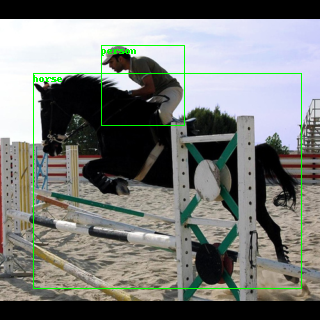

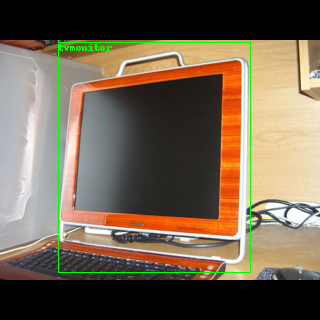

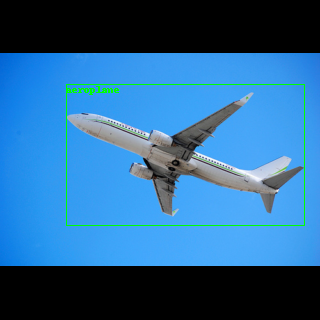

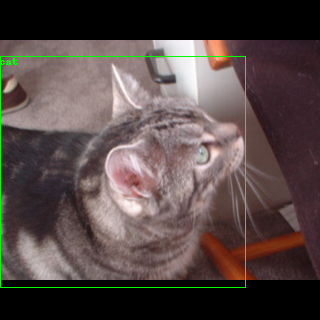

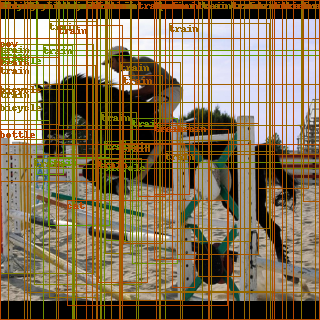

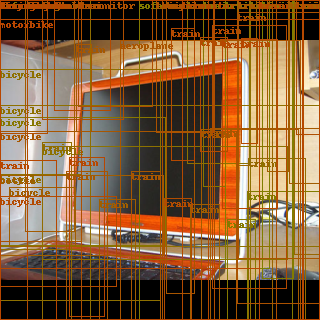

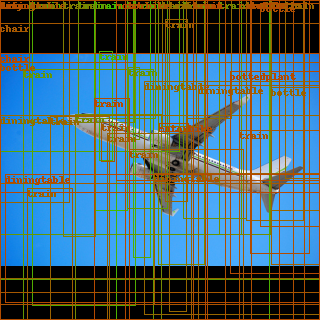

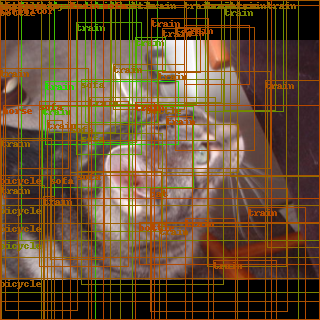

In [6]:
for p in network.conv9.parameters():
    try:
        torch.nn.init.kaiming_normal_(p)
    except ValueError:
        torch.nn.init.normal_(p)
batch_predictions = network(batch_imgs)
show_images_with_boxes(batch_imgs, batch_labels)
show_images_with_boxes(batch_imgs, nms(filter_boxes(batch_predictions, 0.2), 0.5))

Let's now do the training:

In [7]:
batch_size = 64
all_idxs = np.array([int(fn.split("2008_")[-1].split(".jpg")[0]) for fn in sorted(glob.glob("VOCdevkit/VOC2012/JPEGImages/2008_*"))], dtype=int)
lossfunc = YOLOLoss(anchors=network.anchors, coord_prefill=int(5*all_idxs.shape[0]))
optimizer = torch.optim.Adam(network.conv9.parameters(), lr=0.003)

In [8]:
%%time
device=torch.device("cuda")
network = network.to(device)
np.random.RandomState(seed=42).shuffle(all_idxs)
valid_idxs = all_idxs[-4*batch_size:]
train_idxs = all_idxs[:-4*batch_size]

for e in range(20):
    np.random.shuffle(train_idxs)
    range_ = tqdm(np.array_split(train_idxs, batch_size))
    with torch.no_grad():
        valid_imgs = load_image_batch(valid_idxs, size=320).to(device)
        valid_labels = load_bboxes_batch(valid_idxs, size=320, num_bboxes=10)
        valid_predictions = network(valid_imgs, yolo=False)
        valid_loss = lossfunc(valid_predictions, valid_labels).item()
        range_.set_postfix(valid_loss=valid_loss)
    for i, idxs in enumerate(range_):
        optimizer.zero_grad()
        batch_imgs = load_image_batch(idxs, size=320).to(device)
        batch_labels = load_bboxes_batch(idxs, size=320, num_bboxes=10)
        batch_predictions = network(batch_imgs, yolo=False)
        loss = lossfunc(batch_predictions, batch_labels)
        range_.set_postfix(loss=loss.item(), valid_loss=valid_loss)
        loss.backward()
        optimizer.step()

CPU times: user 4h 43min 52s, sys: 8min 6s, total: 4h 51min 59s
Wall time: 19min 17s


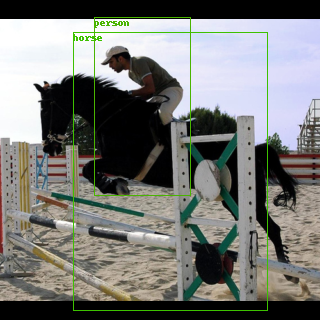

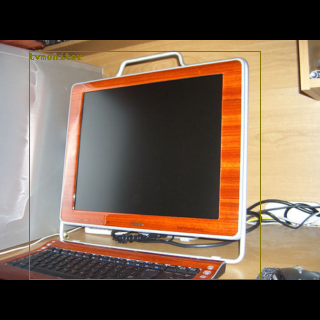

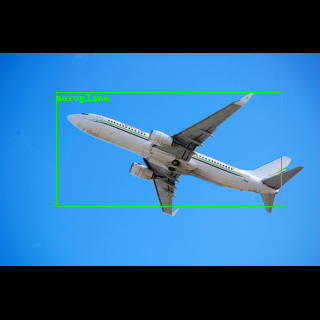

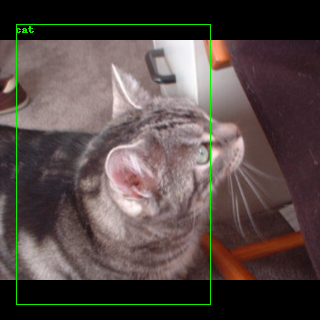

In [9]:
network = network.to("cpu")
imgs = load_image_batch([8, 16, 33, 60], size=320)
output_tensor = network(imgs)
filtered_tensor = filter_boxes(output_tensor, 0.3)
nms_tensor = nms(filtered_tensor, 0.3)
show_images_with_boxes(imgs, nms_tensor)

## Index
* [part 1: introduction to YOLO and TinyYOLOv2 implementation](yolo-
part-1.ipynb)
* **part 2 (this post): towards a YOLO loss function**
* part 3 (in progress): transfer learning with YOLO

## Credits

This part would not have been possible without the excellent
[lightnet](https://gitlab.com/EAVISE/lightnet/-/blob/master/lightnet/network/loss/_regionloss.py)
implementation to guide me. Please check it out for a more complete PyTorch re-
implementation of the YOLO architectures.